In [1]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import error_analysis

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')
import random
from seaborn.algorithms import bootstrap

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both context-unaware and context-aware trained agents.
Code defaults to context-aware, context-unaware results can be loaded by setting the context-unaware flag.

In [2]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
n_epochs = 300
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [3]:
context_unaware = False # whether original or context_unaware simulations are evaluated
if context_unaware:
    setting = 'context_unaware'
else:
    setting = 'standard' # context-aware

## Accuracies

### Training trajectories

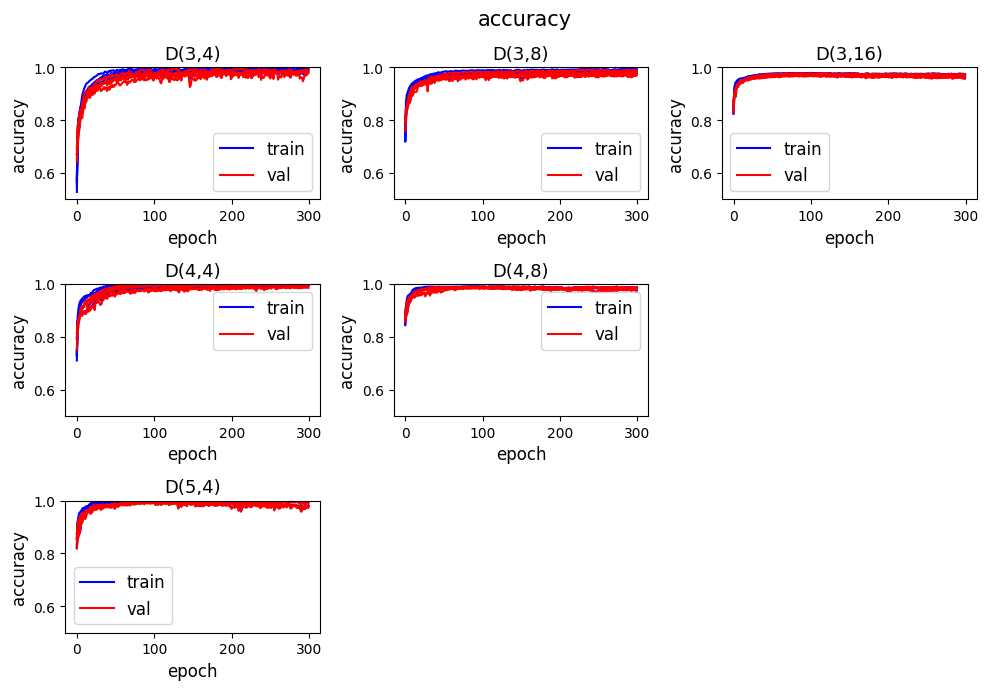

In [4]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=context_unaware)
plot_training_trajectory(all_accuracies['train_acc'], all_accuracies['val_acc'], ylim=(0.5, 1), steps=(1, 1))

### Learning speed

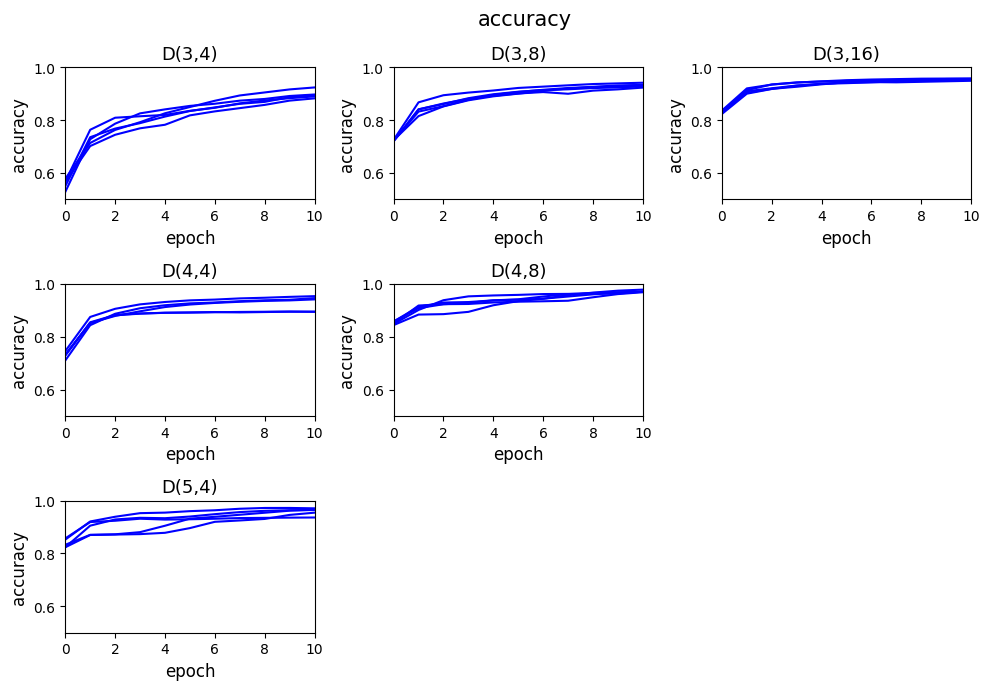

In [5]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=context_unaware)
plot_training_trajectory(all_accuracies['train_acc'], all_accuracies['val_acc'], ylim=(0.5, 1), xlim=(0, 10), steps=(1, 1), train_only=True)

### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [6]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False)
accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc'],
              all_accuracies['cu_train_acc'], all_accuracies['cu_val_acc']]
test_accuracies = [all_accuracies['test_acc'], all_accuracies['cu_test_acc']]

In [10]:
# FIXED:
all_accuracies_no_cu = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False)
all_accuracies_cu = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=True)

accuracies = [all_accuracies_no_cu['train_acc'], all_accuracies_no_cu['val_acc'],
              all_accuracies_cu['cu_train_acc'], all_accuracies_cu['cu_val_acc']]
test_accuracies = [all_accuracies_no_cu['test_acc'], all_accuracies_cu['cu_test_acc']]
print(accuracies[0].shape)

(6, 5, 300)


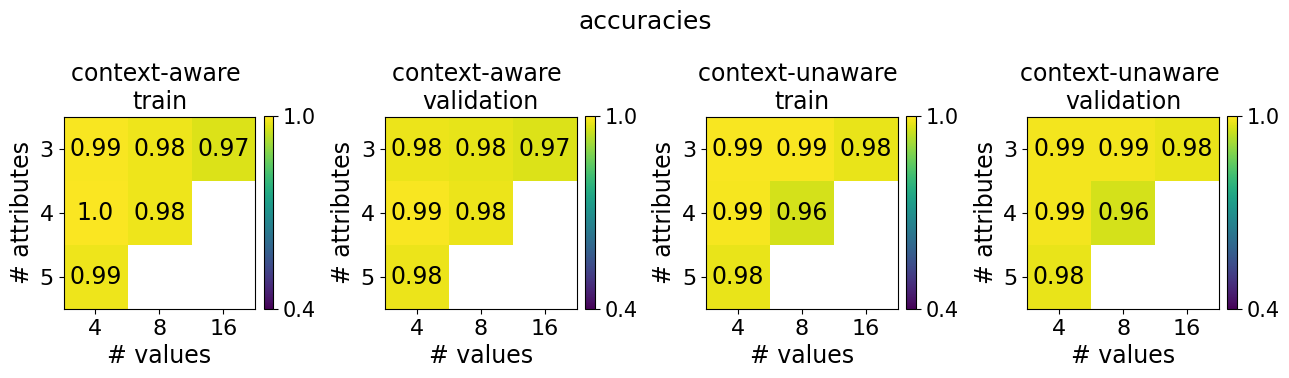

In [7]:
plot_heatmap(accuracies, 'mean', plot_dims=(1,4), ylims=(0.4, 1.0), figsize=(13, 3.5), suptitle='accuracies', 
             fontsize=17)

#### Context-unaware

In [10]:
# training
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies_cu['cu_train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.995, 0.002),
 '(3,8)': (0.993, 0.003),
 '(3,16)': (0.981, 0.007),
 '(4,4)': (0.992, 0.002),
 '(4,8)': (0.961, 0.011),
 '(5,4)': (0.98, 0.011)}

In [11]:
# context unaware
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies_cu['cu_val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.99, 0.003),
 '(3,8)': (0.989, 0.004),
 '(3,16)': (0.979, 0.008),
 '(4,4)': (0.989, 0.002),
 '(4,8)': (0.961, 0.011),
 '(5,4)': (0.979, 0.012)}

#### Context-aware

In [ ]:

final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies_no_cu['train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(3,4)': (0.993, 0.003),
 '(3,8)': (0.984, 0.006),
 '(3,16)': (0.969, 0.005),
 '(4,4)': (0.995, 0.003),
 '(4,8)': (0.984, 0.004),
 '(5,4)': (0.985, 0.007)}

In [17]:
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies_no_cu['val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(3,4)': (0.983, 0.004),
 '(3,8)': (0.977, 0.006),
 '(3,16)': (0.968, 0.006),
 '(4,4)': (0.993, 0.005),
 '(4,8)': (0.982, 0.006),
 '(5,4)': (0.984, 0.008)}

#### Accuracies: Boostrapped CIs

In [18]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

# context-aware (train, val), context-unaware (train, val)
for i in range(len(accuracies)):
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(accuracies[i]) for _ in range(len(accuracies[i]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({lower_percentile}, {upper_percentile}), Mean: {np.mean(bootstrap_means)}")

Bootstrap Confidence Interval (95.0%): (0.9737675321418379, 0.9843448883758651), Mean: 0.9792808368629945
Bootstrap Confidence Interval (95.0%): (0.967433738456832, 0.9834957806401783), Mean: 0.9761085321588714
Bootstrap Confidence Interval (95.0%): (0.9680186563614342, 0.9886802964836359), Mean: 0.9798323659419241
Bootstrap Confidence Interval (95.0%): (0.9685361714694235, 0.9885185881588194), Mean: 0.9798343855975022


### Test accuracies
means and stds

In [19]:
test_accuracies


[array([[0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.63679951, 0.78210992, 0.73057991, 0.66146594, 0.61986005],
        [0.88430744, 0.875736  , 0.86230022, 0.8779186 , 0.87010664],
        [0.86967105, 0.97659606, 0.90132159, 0.98230481, 0.98235208],
        [0.97316808, 0.98245692, 0.96397209, 0.97790849, 0.98108733],
        [0.97328424, 0.97476953, 0.99023068, 0.99163842, 0.96576583]]),
 array([[0.80620968, 0.84601694, 0.86953127, 0.88459015, 0.79134917],
        [0.79291332, 0.83242428, 0.64516675, 0.80349618, 0.81549996],
        [0.90151173, 0.89289147, 0.9005878 , 0.89145035, 0.89126951],
        [0.94437349, 0.9235037 , 0.96043861, 0.88459957, 0.89810252],
        [0.9537003 , 0.95227146, 0.92792135, 0.92769819, 0.95236969],
        [0.98087949, 0.93986893, 0.97019625, 0.96990484, 0.95668417]])]

In [20]:
# first context-aware, then context-unaware
for cond in test_accuracies:
    for i, d in enumerate(datasets):
        print(d, round(np.mean(cond[i]), 3), round(np.std(cond[i]), 3), round(np.min(cond[i]), 2), round(np.max(cond[i]), 2))

(3,4) 0.784 0.035 0.73 0.83
(3,8) 0.686 0.061 0.62 0.78
(3,16) 0.874 0.007 0.86 0.88
(4,4) 0.942 0.048 0.87 0.98
(4,8) 0.976 0.007 0.96 0.98
(5,4) 0.979 0.01 0.97 0.99
(3,4) 0.84 0.036 0.79 0.88
(3,8) 0.778 0.068 0.65 0.83
(3,16) 0.896 0.005 0.89 0.9
(4,4) 0.922 0.028 0.88 0.96
(4,8) 0.943 0.012 0.93 0.95
(5,4) 0.964 0.014 0.94 0.98


## Entropy scores

In [21]:
entropy_scores = load_entropies(paths, context_unaware=context_unaware) # 
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\load_results.py:499: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


### General

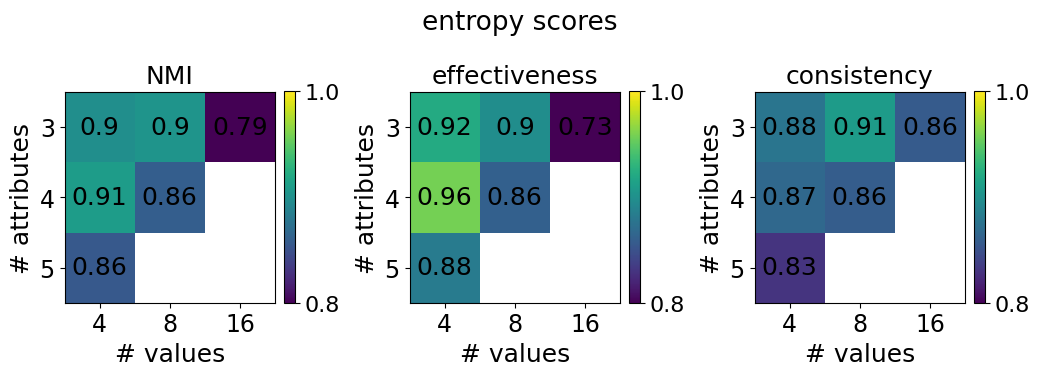

In [22]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='entropy scores')

#### Means and stds

In [23]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'(3,4)NMI': (0.899, 0.014),
 '(3,8)NMI': (0.904, 0.029),
 '(3,16)NMI': (0.79, 0.016),
 '(4,4)NMI': (0.91, 0.014),
 '(4,8)NMI': (0.86, 0.015),
 '(5,4)NMI': (0.856, 0.019),
 '(3,4)effectiveness': (0.922, 0.019),
 '(3,8)effectiveness': (0.898, 0.036),
 '(3,16)effectiveness': (0.732, 0.026),
 '(4,4)effectiveness': (0.958, 0.017),
 '(4,8)effectiveness': (0.861, 0.023),
 '(5,4)effectiveness': (0.883, 0.013),
 '(3,4)consistency': (0.877, 0.012),
 '(3,8)consistency': (0.91, 0.028),
 '(3,16)consistency': (0.858, 0.01),
 '(4,4)consistency': (0.867, 0.015),
 '(4,8)consistency': (0.859, 0.016),
 '(5,4)consistency': (0.83, 0.026)}

#### Bootstraped CIs

In [24]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for i in range(len(entropies)):
    score = list(entropy_scores.keys())[i]
    for idx, d in enumerate(datasets):
        for _ in range(num_bootstrap_samples):
            bootstrap_sample = [random.choice(entropies[i][idx]) for _ in range(len(entropies[i][idx]))]
            bootstrap_mean = np.mean(bootstrap_sample)
            bootstrap_means.append(bootstrap_mean)

        # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
        alpha = (1 - confidence_level) / 2
        lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
        upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
        #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
        entropies_bootstrapped[d + score] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped

{'(3,4)NMI': ((0.89, 0.91), 0.9),
 '(3,8)NMI': ((0.88, 0.93), 0.9),
 '(3,16)NMI': ((0.78, 0.92), 0.86),
 '(4,4)NMI': ((0.78, 0.92), 0.88),
 '(4,8)NMI': ((0.78, 0.92), 0.87),
 '(5,4)NMI': ((0.78, 0.92), 0.87),
 '(3,4)effectiveness': ((0.78, 0.93), 0.88),
 '(3,8)effectiveness': ((0.78, 0.93), 0.88),
 '(3,16)effectiveness': ((0.72, 0.93), 0.86),
 '(4,4)effectiveness': ((0.72, 0.96), 0.87),
 '(4,8)effectiveness': ((0.72, 0.96), 0.87),
 '(5,4)effectiveness': ((0.73, 0.96), 0.87),
 '(3,4)consistency': ((0.73, 0.96), 0.87),
 '(3,8)consistency': ((0.73, 0.96), 0.88),
 '(3,16)consistency': ((0.73, 0.96), 0.87),
 '(4,4)consistency': ((0.73, 0.96), 0.87),
 '(4,8)consistency': ((0.73, 0.96), 0.87),
 '(5,4)consistency': ((0.73, 0.96), 0.87)}

### Concept-dependent

In [25]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Bootstrapping CIs: Concept-level

#### Plotting Concept-level

In [26]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_hierarchical, 
                             'Effectiveness': effectiveness_hierarchical, 'Consistency': consistency_hierarchical}


In [27]:
all_hierarchical = {}
all_hierarchical['metric'] = ['Effectiveness'] * 150 + ['Consistency'] * 150 + ['NMI'] * 150 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'] +
                             entropy_dict_hierarchical['NMI'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

C:\Users\Isabella\AppData\Local\Temp\ipykernel_18612\4195672347.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),


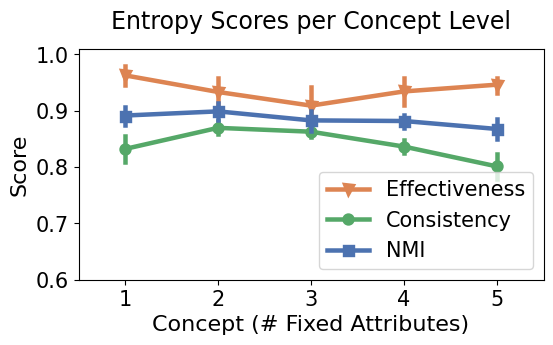

In [28]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Concept Level', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Concept (# Fixed Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

##### one dataset only

In [29]:
all_hierarchical = {}
all_hierarchical['metric'] = ['NMI'] * 25 + ['Effectiveness'] * 25 + ['Consistency'] * 25 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['NMI'] + 
                             entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

In [30]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', 
                   markers=['v', 'o', 's'], palette='deep', scale=1.2)
plt.ylabel('score', fontsize=16)
plt.title('entropy scores per hierarchy level', fontsize=17, y=1.05)
plt.ylim([0.5,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
#plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

ValueError: All arrays must be of the same length

<Figure size 600x300 with 0 Axes>

#### Bootstrapping

In [31]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [32]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([1, 2, 3, 4, 5]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [33]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [1, 2, 3, 4, 5]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,3), round(upper_percentile,3)), round(np.mean(bootstrap_means),3)
entropies_bootstrapped
    

{1: ((0.874, 0.909), 0.892),
 2: ((0.876, 0.912), 0.895),
 3: ((0.869, 0.91), 0.891),
 4: ((0.869, 0.909), 0.889),
 5: ((0.856, 0.908), 0.885)}

### Context-dependent

In [34]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Bootstrapping CIs: Context

In [35]:
# prepare data for bootstrapping
data_for_bootstrapping = {}

for l, level in enumerate([0, 1, 2, 3, 4]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_context_dep'][l])
            except:
                pass
    data_for_bootstrapping[level] = NMI_hierarchical


In [36]:
setting = 'context_unaware'


In [39]:
# prepare data for bootstrapping
NMI_context_unaware = {}

for l, level in enumerate([0, 1, 2, 3, 4]):
    NMI_hierarchical = []

    for d, data in enumerate(datasets):
        for run in range(5):
            
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))

            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_context_dep'][l])
            except:
                pass
    #data_for_bootstrapping[level] = NMI_hierarchical
    if setting == 'standard':
        "hi"
        NMI_standard[level] = NMI_hierarchical
    else:
        NMI_context_unaware[level] = NMI_hierarchical


In [38]:
print(len(NMI_context_unaware[0]))
print(len(NMI_standard[0]))

30


NameError: name 'NMI_standard' is not defined

In [ ]:
from pingouin import ttest

ttest(NMI_context_unaware[0], NMI_standard[0], alternative='two-sided')


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.610556,58,two-sided,2.759296e-10,"[0.05, 0.08]",1.965037,2.62e+07,1.0


In [40]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

entropies_bootstrapped = {}

for level in [0, 1, 2, 3, 4]: 
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(data_for_bootstrapping[level]) for _ in range(len(data_for_bootstrapping[level]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
    entropies_bootstrapped[level] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
entropies_bootstrapped
    

{0: ((0.87, 0.9), 0.88),
 1: ((0.87, 0.91), 0.89),
 2: ((0.87, 0.92), 0.9),
 3: ((0.88, 0.95), 0.91),
 4: ((0.88, 0.96), 0.92)}

#### Plotting per Context condition

In [41]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'Effectiveness': effectiveness_context_dep, 'Consistency': consistency_context_dep}


In [42]:
all_context_dep = {}
all_context_dep['metric'] = ['Effectiveness'] * 150 + ['Consistency'] * 150 +['NMI'] * 150 
all_context_dep['value'] = (entropy_dict_context_dep['Effectiveness'] + 
                             entropy_dict_context_dep['Consistency'] +
                             entropy_dict_context_dep['NMI']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

C:\Users\Isabella\AppData\Local\Temp\ipykernel_18612\574820416.py:2: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),


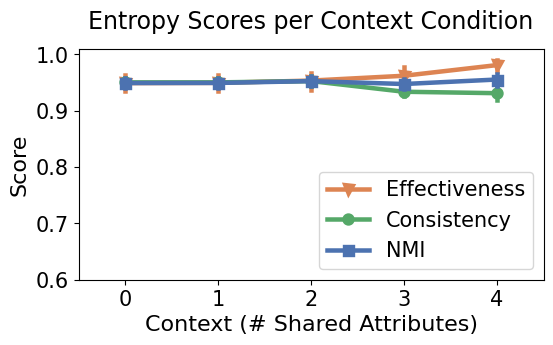

In [43]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]), 
                   scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Context Condition', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Context (# Shared Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

### Concept x Context

In [44]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


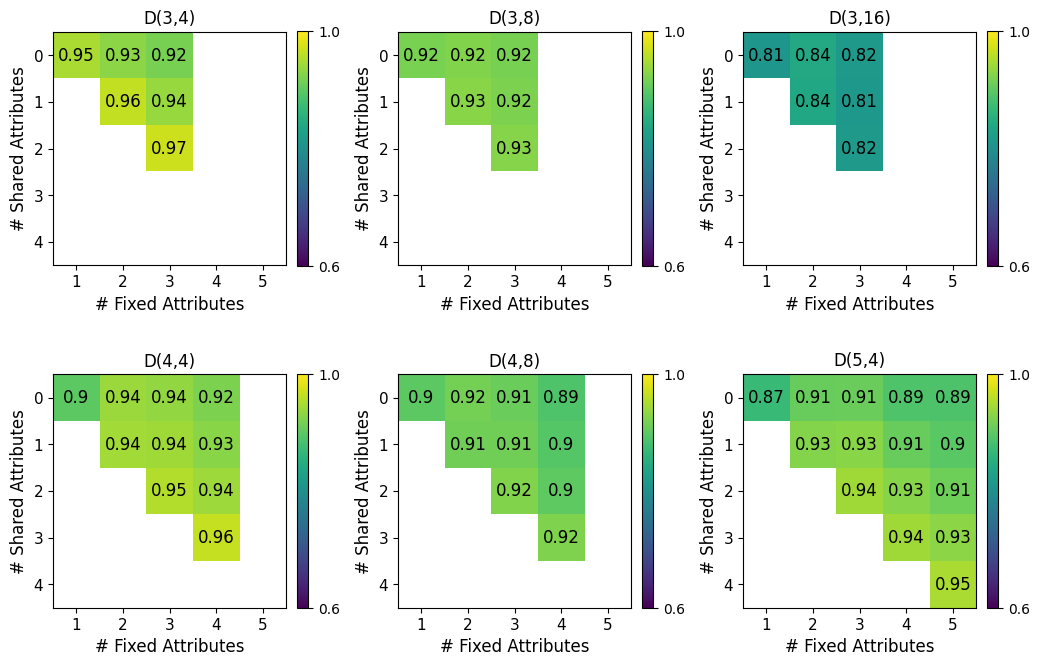

In [45]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

#### effectiveness

c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


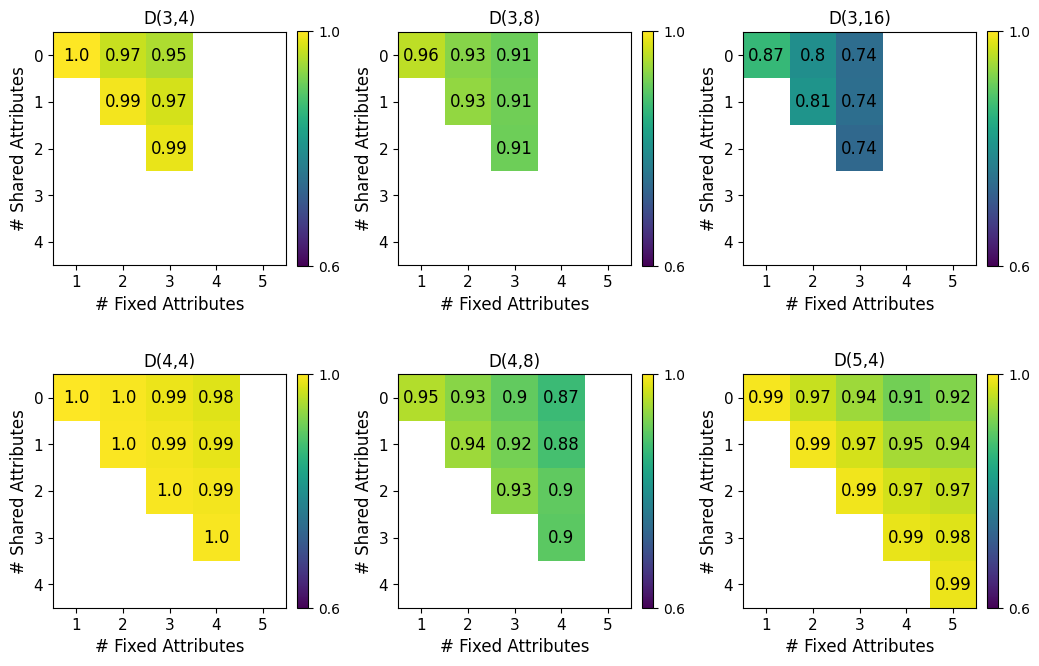

In [46]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='effectiveness', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

#### consistency

c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


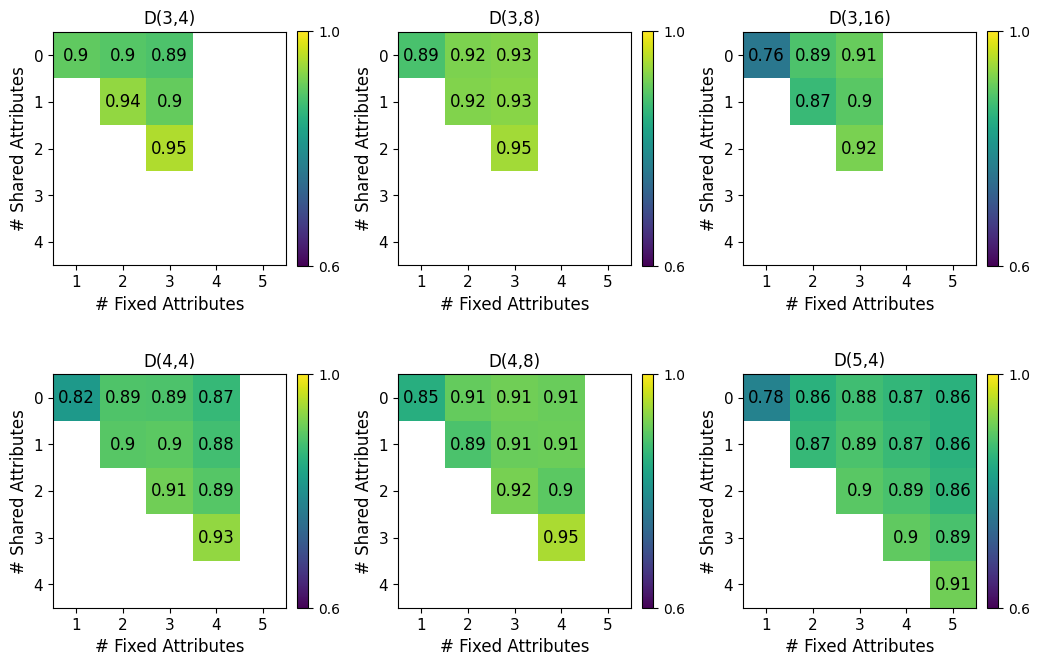

In [47]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='consistency', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

## Message length

In [48]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

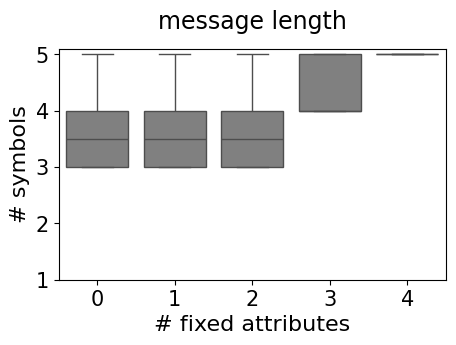

In [49]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, color='gray')
plt.xticks(fontsize=15)
plt.yticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
plt.title('message length', fontsize=17, y=1.05)
plt.show()

## Symbol redundancy

In [52]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

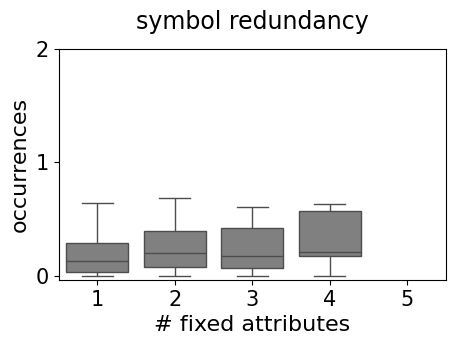

In [53]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(ticks=[0, 1, 2], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## Compositionality

In [54]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_generic, posdis_generic, bosdis_generic = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        posdis_specific[d, run] = disent_score['posdis_specific']
        bosdis_specific[d, run] = disent_score['bosdis_specific']
        topsim_generic[d, run] = topsim_score['topsim_generic_train']
        posdis_generic[d, run] = disent_score['posdis_generic']
        bosdis_generic[d, run] = disent_score['bosdis_generic']

### Topsim

In [55]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.46 sd 0.07
(3,8) topsim: 0.411 sd 0.06
(3,16) topsim: 0.287 sd 0.04
(4,4) topsim: 0.418 sd 0.04
(4,8) topsim: 0.336 sd 0.05
(5,4) topsim: 0.431 sd 0.06


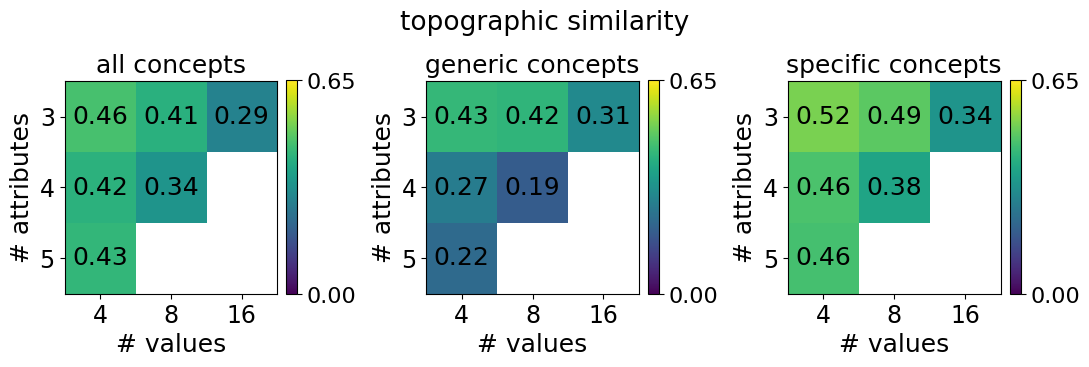

In [56]:
plot_heatmap([topsim, topsim_generic, topsim_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5), 
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

#### Topographic similarity over time

In [57]:
topsim_over_time = {}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/topsim_over_time.pkl', 'rb'))
            
        topsim_over_time[d][run] = scores
            
plt.plot(topsim_over_time[0][0])
round(max(topsim_over_time[0][0]) - min(topsim_over_time[0][0]), 3)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_3/context_unaware/0/topsim_over_time.pkl'

### Posdis

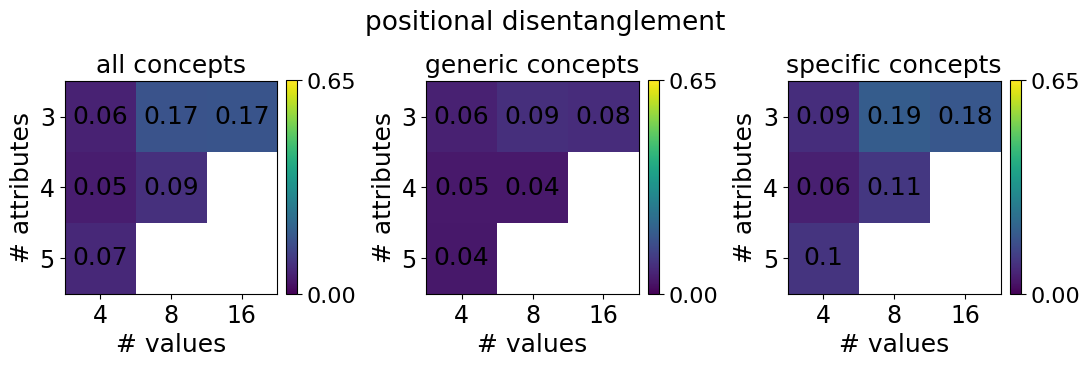

In [58]:
plot_heatmap([posdis, posdis_generic, posdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

In [60]:
posdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_scores.pkl', 'rb')))
    posdis.append(sublist)

c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


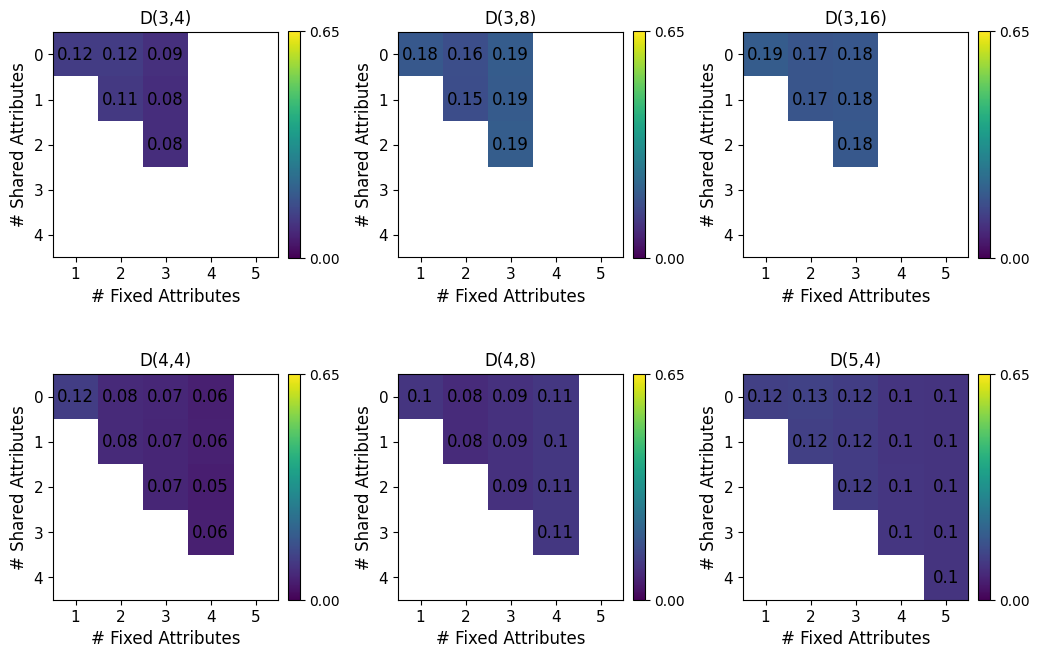

In [61]:
plot_heatmap_concept_x_context(posdis, score='posdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Bosdis

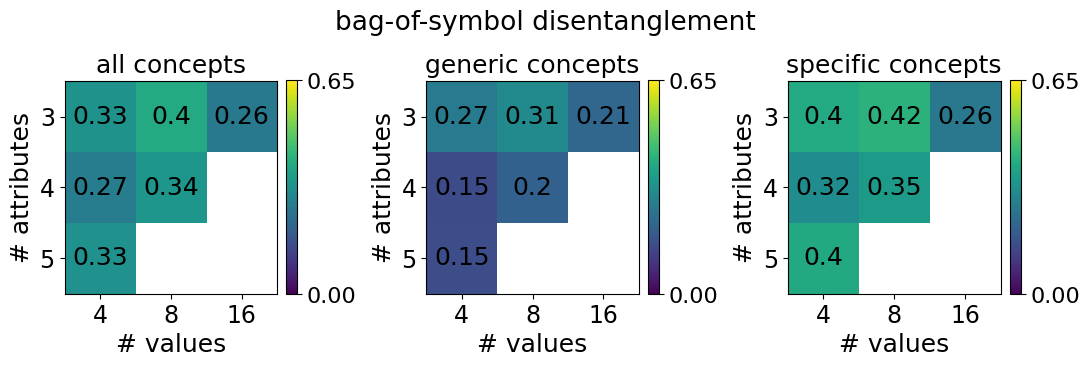

In [62]:
plot_heatmap([bosdis, bosdis_generic, bosdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [63]:
bosdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/bosdis_scores.pkl', 'rb')))
    bosdis.append(sublist)

c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)
c:\Users\Isabella\Desktop\HiWi\emergent-abstractions\utils\plot_helpers.py:142: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


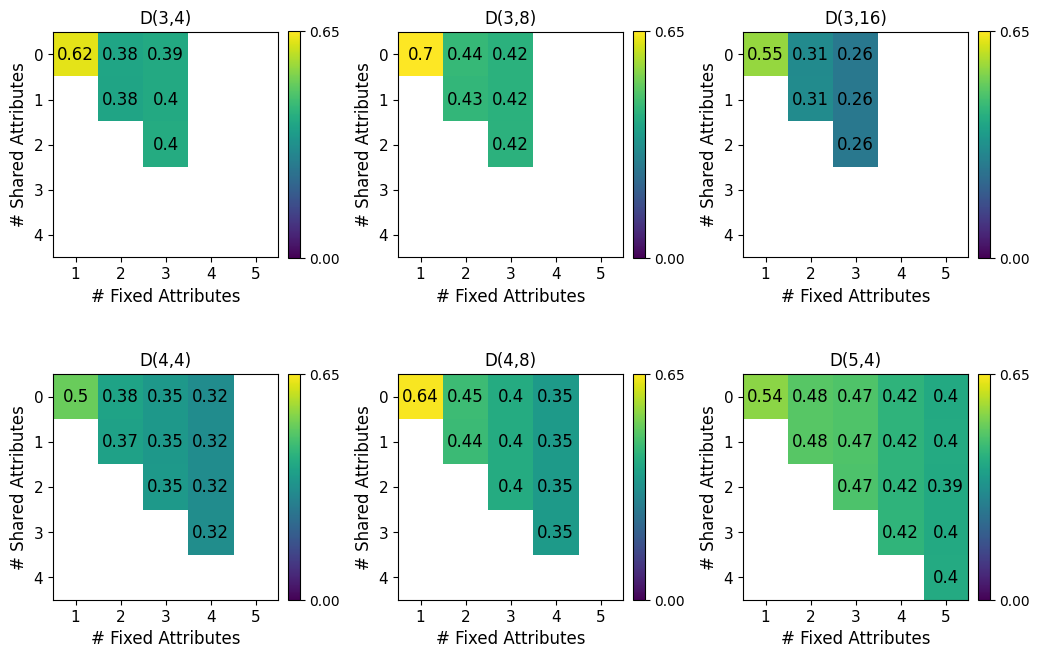

In [64]:
plot_heatmap_concept_x_context(bosdis, score='bosdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Compositionality per dataset

In [65]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

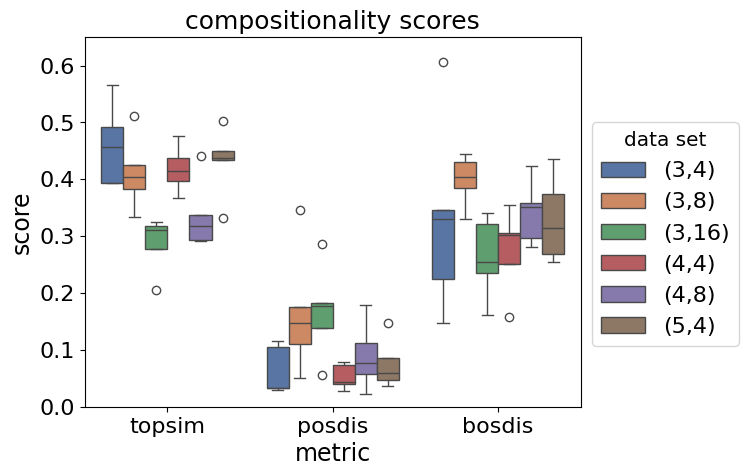

In [66]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

## Errors

In [67]:
validation = True # set to false if training interaction should be used
setting = 'standard'

In [68]:
import torch
from utils.analysis_from_interaction import *

In [69]:
def error_analysis(datasets, paths, setting, n_epochs, n_values, validation=True):
    """
    goes through interactions, retrieves concept and context conditions and counts errors, 
    i.e. incorrectly classified objects (by the receiver)
    """
    all_error_concepts = {}
    all_error_contexts = {}
    all_error_concept_x_context = {}
    all_false_positives = {}
    all_false_negatives = {}
    all_total_errs = {}

    all_acc_concept_x_context = {}

    all_total_concepts = {}
    all_total_contexts = {}
    all_total_concept_x_context = {}

    # go through all datasets
    for i, d in enumerate(datasets):
        print(i, d)
        error_concepts = {}
        error_contexts = {}
        error_concept_x_context = {}
        false_positives = {}
        false_negatives = {}
        total_errs = {}
        acc_concept_x_context = {}
        # select first run
        path_to_run = paths[i] + '/' + str(setting) + '/' + str(0) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        if validation:
            interaction = torch.load(path_to_interaction_val)
        else:
            interaction = torch.load(path_to_interaction_train)

        total_concepts = obtain_concept_counts(interaction.sender_input, n_values[i])

        total_contexts = obtain_context_counts(interaction.sender_input, n_values[i])

        total_concept_x_context = obtain_concept_x_context_counts(interaction.sender_input, n_values[i])

        for j in range(len(interaction.sender_input)):
            receiver_pred = (interaction.receiver_output[j][-1] > 0).float()  # use last symbol of message

            (objects, fixed) = get_fixed_vectors(interaction.sender_input, n_values[i], j)
            concept_str = str(int(sum(fixed[0])))

            context_conds = get_context_cond(interaction.sender_input, n_values[i], j, objects, fixed)
            context_str = str(context_conds[0])
            concept_x_context_str = (context_conds[0], int(sum(fixed[0]) - 1))
            
            # check if receiver has classified all objects correctly as targets or distractors
            if not torch.equal(receiver_pred, interaction.labels[j]):
                if concept_str in error_concepts:
                    error_concepts[concept_str] += 1
                else:
                    error_concepts[concept_str] = 1

                if context_str in error_contexts:
                    error_contexts[context_str] += 1
                else:
                    error_contexts[context_str] = 1

                if concept_x_context_str in error_concept_x_context:
                    error_concept_x_context[concept_x_context_str] += 1
                else:
                    error_concept_x_context[concept_x_context_str] = 1
                    
                # calculate false positives and false negatives
                num_false_pos = 0
                num_false_neg = 0
                errors = receiver_pred - interaction.labels[j]
                for error in errors:
                    # false positives
                    if error > 0:
                        num_false_pos += 1
                    # false negatives
                    elif error < 0:
                        num_false_neg += 1
                if concept_x_context_str in false_positives:
                    false_positives[concept_x_context_str] += num_false_pos
                else:
                    false_positives[concept_x_context_str] = num_false_pos
                if concept_x_context_str in false_negatives:
                    false_negatives[concept_x_context_str] += num_false_neg
                else:
                    false_negatives[concept_x_context_str] = num_false_neg
                if concept_x_context_str in total_errs:
                    total_errs[concept_x_context_str] += (num_false_pos + num_false_neg)
                else:
                    total_errs[concept_x_context_str] = (num_false_pos + num_false_neg)
                #print("per round", error_concept_x_context)
                #print("total", total_errs)

            # check if receiver has classified some objects correctly as targets or distractors
            # (this is how the accuracy is calculated during training)
            if concept_x_context_str in acc_concept_x_context:
                acc_concept_x_context[concept_x_context_str] += (
                    (receiver_pred == interaction.labels[j]).float().mean().numpy())
            else:
                acc_concept_x_context[concept_x_context_str] = (
                        receiver_pred == interaction.labels[j]).float().mean().numpy()
                
        #print(error_concept_x_context)
        #print("total errs", total_errs)
        #print("total cxc", total_concept_x_context)

        all_error_concepts[d] = error_concepts
        all_error_contexts[d] = error_contexts
        all_error_concept_x_context[d] = error_concept_x_context
        all_false_positives[d] = false_positives
        all_false_negatives[d] = false_negatives
        all_total_errs[d] = total_errs

        all_acc_concept_x_context[d] = acc_concept_x_context

        all_total_concepts[d] = total_concepts
        all_total_contexts[d] = total_contexts
        all_total_concept_x_context[d] = total_concept_x_context

    return (all_error_concepts, all_error_contexts, all_error_concept_x_context, 
            all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
            all_total_concepts, all_total_contexts, all_total_concept_x_context)

In [70]:
(all_error_concepts, all_error_contexts, all_error_concept_x_context, 
 all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
 all_total_concepts, all_total_contexts, all_total_concept_x_context) = error_analysis(datasets, paths, setting, n_epochs, n_values, validation)

0 (3,4)


C:\Users\Isabella\AppData\Local\Temp\ipykernel_18612\2417222200.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  interaction = torch.load(path_to_interaction_val)


FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_3/standard/0/interactions/validation/epoch_300/interaction_gpu0'

In [71]:
err_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_error_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_error_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    err_ratio_concept_x_context[d] = ratio_concept_x_context

NameError: name 'all_total_concept_x_context' is not defined

In [ ]:
all_total_errs['(3,4)'] # how many objects were classified incorrectly per condition

{(2, 2): 92, (0, 1): 17, (1, 1): 60}

In [72]:
all_error_concept_x_context['(3,4)'] # how often data in a specific condition was classified incorrectly

NameError: name 'all_error_concept_x_context' is not defined

In [ ]:
all_total_concept_x_context['(3,4)'] # how often the specific concept x context condition is present in the interaction

{(0, 2): 118, (2, 2): 144, (1, 2): 121, (1, 1): 101, (0, 1): 91, (0, 0): 21}

In [ ]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    print(d)
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        print(concept_x_context)
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / #* (all_total_errs[d][concept_x_context] / 
            all_total_concept_x_context[d][concept_x_context], 4)
            #print(all_false_positives[d][concept_x_context] / all_total_errs[d][concept_x_context])
            print(all_total_errs[d][concept_x_context], all_total_concept_x_context[d][concept_x_context], all_total_errs[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
            print(all_false_positives[d][concept_x_context], all_false_positives[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

(3,4)
(0, 2)
(2, 2)
92 144 0.6388888888888888
92 0.6388888888888888
(1, 2)
(1, 1)
60 101 0.594059405940594
23 0.22772277227722773
(0, 1)
17 91 0.18681318681318682
0 0.0
(0, 0)
(3,8)
(1, 1)
190 402 0.472636815920398
40 0.09950248756218906
(0, 2)
1 1022 0.0009784735812133072
1 0.0009784735812133072
(2, 2)
370 1025 0.36097560975609755
370 0.36097560975609755
(1, 2)
12 986 0.012170385395537525
12 0.012170385395537525
(0, 1)
117 399 0.2932330827067669
0 0.0
(0, 0)
26 44 0.5909090909090909
0 0.0
(3,16)
(1, 2)
303 8253 0.036713922210105415
133 0.016115351993214587
(2, 2)
4144 8132 0.5095917363502214
3954 0.48622725036891296
(0, 1)
739 1562 0.4731113956466069
10 0.006402048655569782
(0, 2)
134 8168 0.016405484818805095
4 0.0004897159647404506
(1, 1)
1150 1561 0.7367072389493914
456 0.29212043561819345
(0, 0)
226 92 2.4565217391304346
11 0.11956521739130435
(4,4)
(1, 3)
(1, 2)
71 495 0.14343434343434344
0 0.0
(3, 3)
283 526 0.5380228136882129
283 0.5380228136882129
(1, 1)
56 188 0.2978723404255

In [ ]:
false_objects_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_total_errs[d]:
            ratio_concept_x_context[concept_x_context] = round(all_total_errs[d][concept_x_context] / (all_total_concept_x_context[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_objects_ratio[d] = ratio_concept_x_context

In [ ]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

In [ ]:
false_negatives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_negatives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_negatives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_negatives_ratio[d] = ratio_concept_x_context

In [ ]:
acc_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_acc_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_acc_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    acc_ratio_concept_x_context[d] = ratio_concept_x_context

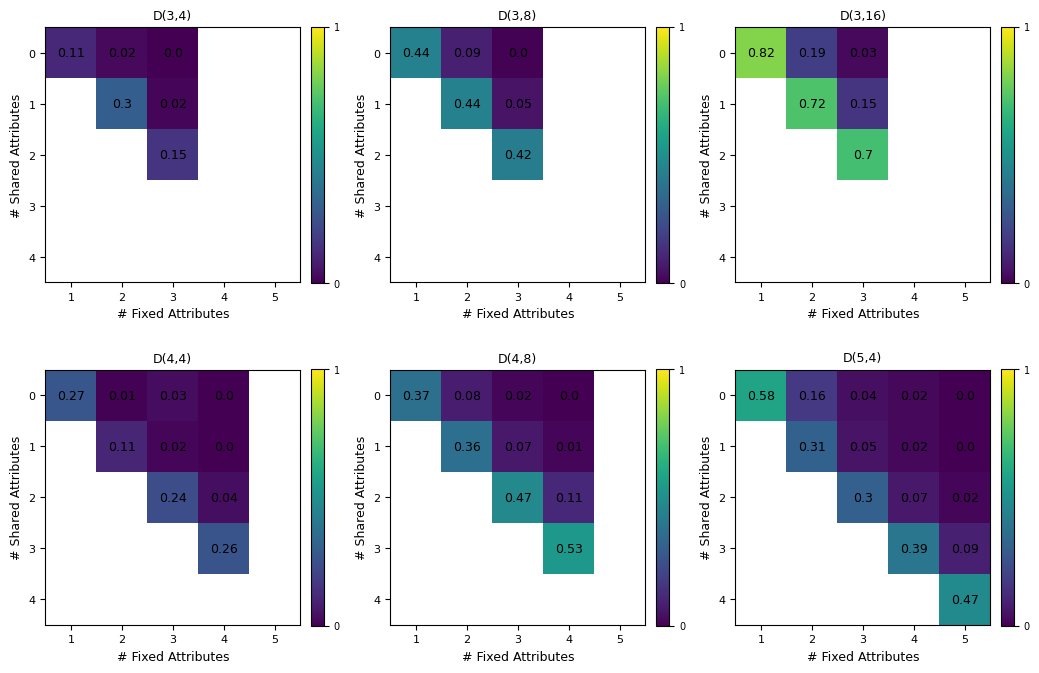

In [ ]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

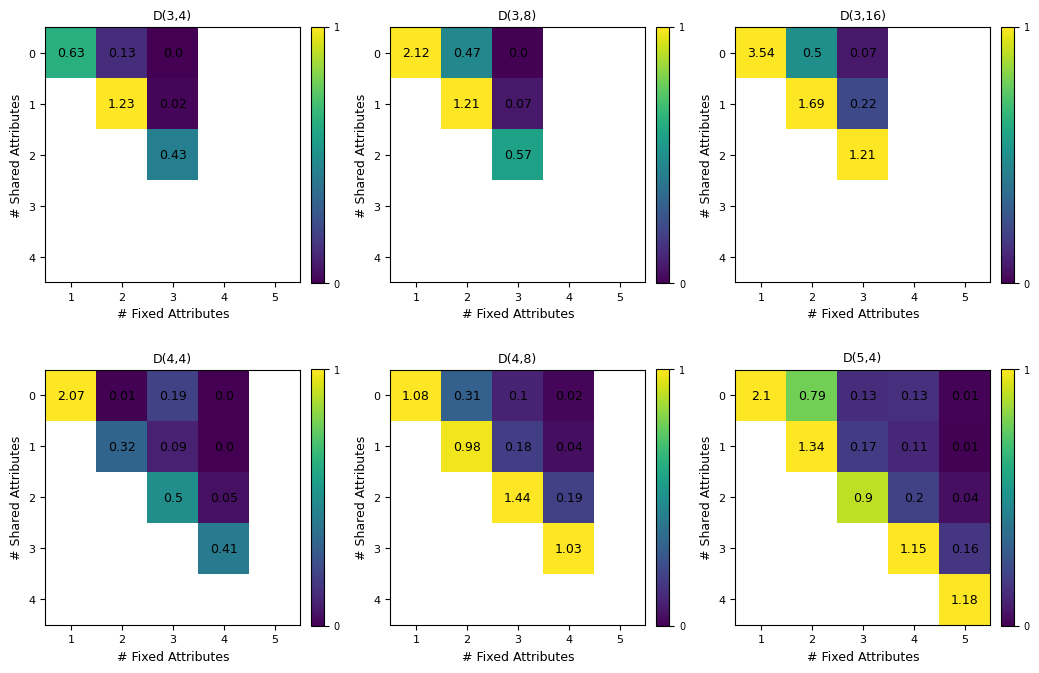

In [ ]:
plot_heatmap_concept_x_context_errors(false_objects_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

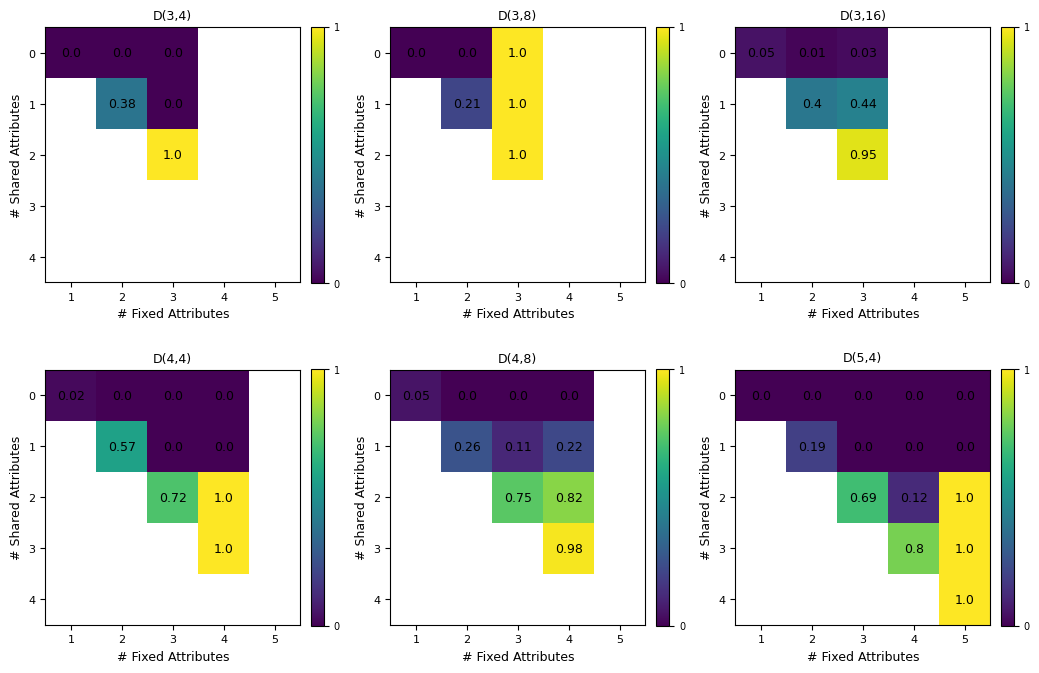

In [ ]:
plot_heatmap_concept_x_context_errors(false_positives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

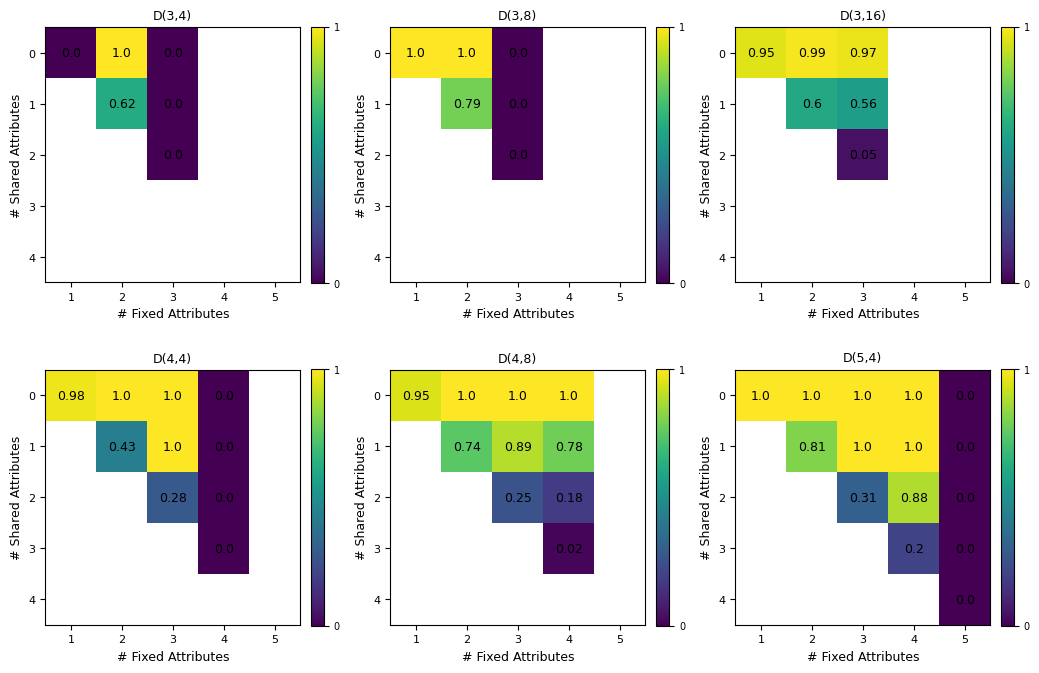

In [ ]:
plot_heatmap_concept_x_context_errors(false_negatives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

In [ ]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
# objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)] # 1.79
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0)] # 2.58
objects = [(2, 1, 0,), (2, 0, 1), (2, 2, 2), (1, 1, 1), (0, 1, 0), (1, 0, 0)] # 2.58

# 1. Bestimme die Häufigkeit jedes einzigartigen Objekts in der Liste
object_counts = Counter(objects)

# 2. Berechne die relative Häufigkeit jedes Objekts
total_objects = len(objects)
object_probabilities = {obj: count / total_objects for obj, count in object_counts.items()}

# 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
entropy = -sum(prob * np.log2(prob) for prob in object_probabilities.values())

# Ausgabe der berechneten Entropie
print("Die berechnete Entropie beträgt:", entropy)

Die berechnete Entropie beträgt: 2.584962500721156


In [ ]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)]

# Transpose the list of objects to get attributes as columns
attributes = np.array(objects).T

# Initialize a list to store the entropy for each attribute
attribute_entropy = []

# Calculate entropy for each attribute
for attribute_values in attributes:
    # 1. Bestimme die Häufigkeit jedes einzigartigen Werts in der Liste
    attribute_counts = Counter(attribute_values)
    
    # 2. Berechne die relative Häufigkeit jedes Werts
    total_values = len(attribute_values)
    value_probabilities = {value: count / total_values for value, count in attribute_counts.items()}
    
    # 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
    entropy = -sum(prob * np.log2(prob) for prob in value_probabilities.values() if prob != 0)
    
    attribute_entropy.append(entropy)

# Ausgabe der berechneten Entropie für jedes Attribut
print("Die berechnete Entropie für jedes Attribut beträgt:", attribute_entropy)

Die berechnete Entropie für jedes Attribut beträgt: [0.6500224216483541, 0.6500224216483541, 0.6500224216483541]


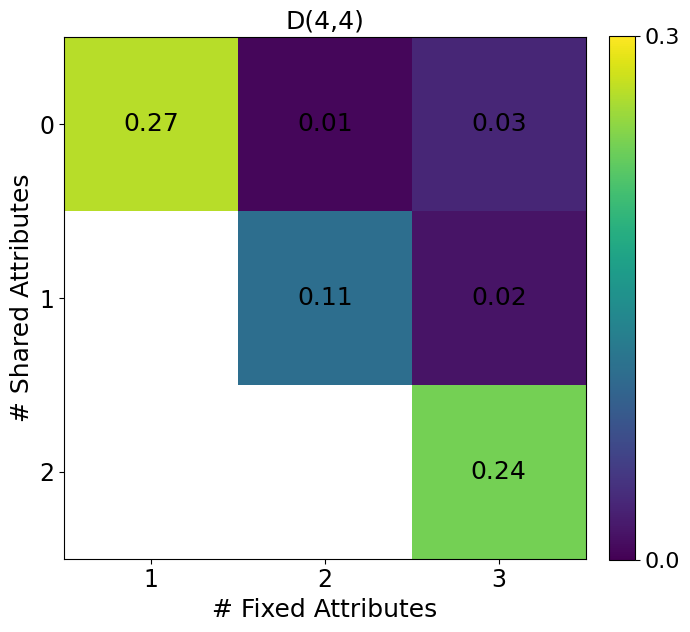

In [ ]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context['(4,4)'], one_dataset=True, attributes=4, titles=('D(4,4)',), ylims=(0, 0.3), plot_dims=(1, 1))

## co-occurrences (not done yet)

In [ ]:
# Not done (yet)
full_plot = False

fig = plt.figure(figsize=(12,3))

for d, dim in enumerate(datasets): 
    
    data = datasets[d]
    path = paths[d]
    vs_factor = int(path[-2])
    vocab_size = (n_values[d] + 1) * vs_factor + 1
    colors = plt.cm.jet(np.linspace(0,1,vocab_size))
    
    average_cooccurences = []
    
    plt.subplot(1,6,d+1)
    
    for run in range(5):
        
        cooccurences = pickle.load(open(paths[d] + 'standard/' + str(run) + '/normalized_cooccurrence.pkl', 'rb'))
        indices = np.flip(np.argsort(cooccurences[:,-1]))
        cooccurences = cooccurences[indices]
        average_cooccurences.append(cooccurences)
        
    average_cooccurences = np.flip(np.mean(average_cooccurences, axis=0), axis=1)
    
    data_dict = {}
    data_dict['symbol rank'] = []
    data_dict['level'] = []
    data_dict['value'] = []
    for symbol in indices:
        for level in range(average_cooccurences.shape[1]):
            data_dict['symbol rank'].append(symbol+1)
            data_dict['level'].append(level)
            data_dict['value'].append(average_cooccurences[symbol, level])
    
    if full_plot:
        g = sns.heatmap(average_cooccurences, cmap='viridis')
        plt.yticks(ticks=[0.5,vocab_size-1.5], labels=[1,vocab_size], fontsize=14)
    else: 
        g = sns.heatmap(average_cooccurences[0:10,:], cmap='viridis')
        plt.yticks(ticks=[0.5,9.5], labels=[1,10], fontsize=14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=13)
    for _, spine in g.spines.items():
        spine.set_visible(True)
    #plt.xlabel('# relevant attributes', fontsize=14)
    #plt.ylabel('symbol rank', fontsize=14)
    plt.xticks(ticks=np.arange(n_attributes[d])+0.5, labels=range(1,n_attributes[d]+1), fontsize=14)
    plt.title(data, fontsize=14)
    
    fig.text(0.5, -0.05, '# relevant attributes', ha='center', va='center', fontsize=15, alpha=0.3)
    fig.text(-0.01, 0.5, 'symbol rank', ha='center', va='center', rotation='vertical', fontsize=15, alpha=0.3)

plt.tight_layout()